In [150]:
!pip install lancedb rerankers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
!git clone https://huggingface.co/datasets/Sanyam/MM-Demo

Cloning into 'MM-Demo'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 24 (delta 4), reused 0 (delta 0), pack-reused 4 (from 1)
Unpacking objects: 100% (24/24), 861.87 KiB | 5.04 MiB/s, done.


In [10]:
!wget https://huggingface.co/datasets/Sanyam/MM-Demo/resolve/main/archive.zip?download=true -O archive.zip

--2024-10-01 12:40:13--  https://huggingface.co/datasets/Sanyam/MM-Demo/resolve/main/archive.zip?download=true
Resolving huggingface.co (huggingface.co)... 18.238.176.118, 18.238.176.103, 18.238.176.8, ...
Connecting to huggingface.co (huggingface.co)|18.238.176.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/cd/e8/cde814535d30074dcdff9e1ffb015dfa1cc1e60be4b2906951b47df88d9571ed/89615a7f69ba75f09c19dc40e4214110134c6f533f950b2894440ee0741d8c53?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27archive.zip%3B+filename%3D%22archive.zip%22%3B&response-content-type=application%2Fzip&Expires=1728045614&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyODA0NTYxNH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2NkL2U4L2NkZTgxNDUzNWQzMDA3NGRjZGZmOWUxZmZiMDE1ZGZhMWNjMWU2MGJlNGIyOTA2OTUxYjQ3ZGY4OGQ5NTcxZWQvODk2MTVhN2Y2OWJhNzVmMDljMTlkYzQwZTQyMTQxMTAxMzRjNmY1Mz

In [ ]:
!unzip archive.zip

In [14]:
import pandas as pd

df = pd.read_csv("data.csv")

In [33]:
df["description"][0]

'end_header_id|>\n\n{"Title": "Graphic T-Shirt", "Size": "S", "Category": "T-Shirt", "Gender": "U", "Type": "Casual", "Description": "This short-sleeved T-shirt features a gray color with a graphic print of a sailboat and a person in the middle. The graphic is primarily white, with yellow and blue accents, and includes a large "6 6 8" logo on the front, as well as additional smaller text that is difficult to decipher. The shirt is laid flat on a pink sheet, providing a contrasting background that highlights the shirt\'s details."}<|eot_id|>'

In [99]:
import re
import json
def fix_unescaped_quotes(json_string):
    # Find the "Description" field and its content
    pattern = r'"Description"\s*:\s*"(.*?)"(?=\s*[,}])'
    
    def escape_quotes(match):
        # Escape any unescaped quotes in the description content
        content = match.group(1)
        escaped_content = re.sub(r'(?<!\\)"', r'\"', content)
        return f'"Description":"{escaped_content}"'
    
    # Replace the Description field with properly escaped content
    fixed_json = re.sub(pattern, escape_quotes, json_string)
    # Now we can safely parse the JSON
    try:
        fixed_json = "{" + fixed_json.split("{")[1].split("}")[0] + "}"
        return json.loads(fixed_json)
    except:
        return {
        'Title': "", 'Size': "" , 'Category': "" , 'Gender': "" , 'Type': "" , 'Description': ""
        }

In [100]:
data = fix_unescaped_quotes(df["description"][0])
data.keys()

dict_keys(['Title', 'Size', 'Category', 'Gender', 'Type', 'Description'])

In [105]:
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.rerankers import ColbertReranker

model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5", device="cuda")


class Schema(LanceModel):
    filename: str
    Description: str = model.SourceField()
    vector: Vector(model.ndims()) = model.VectorField()
    Title: str
    Size: str
    Category: str
    Type: str
    Gender: str
    
db = lancedb.connect("~/.lancedb")
tbl = db.create_table(name="clothes", schema=Schema, mode="overwrite")

[2024-10-01T13:54:24Z WARN  lance::dataset] No existing dataset at /home/jupyter/.lancedb/clothes.lance, it will be created


In [102]:
data = [
    {
        "filename": row["filename"],
        **fix_unescaped_quotes(row["description"])
    } for index, row in df.iterrows()
]

In [104]:
empty_count = len([d for d in data if d.get('Description', '').strip() == ''])
print(empty_count)

15


In [106]:
# automatically generate vectors
tbl.add(data)

In [107]:
tbl.search().to_pandas()

,filename,Description,vector,Title,Size,Category,Type,Gender
0,751b23f7-973b-4ae1-943c-e6a94d0b98f0.jpg,This short-sleeved T-shirt features a gray col...,"[-0.0042564264, 0.0655556, -0.014013509, -0.02...",Graphic T-Shirt,S,T-Shirt,Casual,U
1,97cddbc9-a59f-490e-a10d-7878b2aff826.jpg,"A short-sleeved, solid pink blouse with a scoo...","[-0.022669869, 0.048171166, 0.003178434, -0.00...",Pink Blouse,M,Tops,Casual,F
2,6190369c-a306-4fb6-801e-98ddcbe21435.jpg,These black sneakers feature yellow details on...,"[-0.045041706, -0.011831723, 0.014727246, 0.00...",Black Sneakers with Yellow Details,S,Shoes,Casual,F
3,fd2d5fd1-2572-48d1-a089-f44039543b50.jpg,These are a pair of medium-washed denim pants ...,"[-0.037305575, 0.08401107, 0.044987984, -0.013...",Denim Pants,M,Pants,Casual,U
4,ee23222a-f46f-4044-abb2-0a5d1795da36.jpg,"A long-sleeved shirt with a plaid pattern, fea...","[-1.7170775e-06, 0.07057334, -0.07675235, 0.06...",Long-Sleeved Shirt,L,Shirts,Casual,M
5,18a573de-219f-44de-8dc9-0a64422e4f99.jpg,,"[0.048461664, -0.0012961804, 0.016879026, -0.0...",,,,,
6,23636f41-67c0-4065-b82a-6fd0d3704c07.jpg,This vibrant top features a colorful fruit pat...,"[-0.0075272345, -0.0083891535, -0.022784384, -...",Fruit printed top,S,T-Shirt,Casual,F
7,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F
8,9f747796-8b18-4019-ab9e-3a3e3cf60590.jpg,,"[0.048461664, -0.0012961804, 0.016879026, -0.0...",,,,,
9,a4e185b1-0720-4553-bae0-76a2bda26dba.jpg,These light gray fleece shorts are a versatile...,"[-0.05891305, 0.0793806, 0.017159712, -0.03977...",Fleece Shorts,S,Shorts,Casual,U


In [121]:
from pathlib import Path
from PIL import Image
def show_image_from_response(rs):
    names = rs["filename"].to_list()
    return [Image.open(Path("archive")/ "images_compressed" / name) for name in  names]
    

### Pattern 1: text input

In [108]:
## TODO: turn this into a loop chat & also add image example
prompt = input()
"""
what clothes would go with A long-sleeved shirt with a plaid pattern. Please answer within 100 words consisely and only provide the answer don't 
repeat any word from the input, start your response from the clothing items that can be paired with the input

"""

 what clothes would go with A long-sleeved shirt with a plaid pattern


In [138]:
dummy_model_response = """
Jeans, trousers, or a skirt can be paired with a long-sleeved shirt with a plaid pattern. For a casual look, try pairing it with jeans and boots. 
For a more formal look, pair it with trousers and dress shoes. A skirt can also add a feminine touch to the outfit. 
To balance the boldness of the plaid pattern, consider adding a neutral-colored jacket or cardigan.
"""

In [130]:
# automatically converted to vector respresentation
rs = tbl.search(dummy_model_response).limit(3).to_pandas()
rs


,filename,Description,vector,Title,Size,Category,Type,Gender,_distance
0,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F,0.366177
1,10e51a41-3729-472e-b288-f3b8f895577a.jpg,This plaid shirt features a classic plaid patt...,"[-0.044541422, 0.05006024, -0.04257077, 0.0401...",Plaid shirt with embroidered hem,L,Tops,Casual,F,0.366811
2,b0c03127-9dfb-4573-8934-1958396937bf.jpg,This red flannel plaid shirt has a classic and...,"[-0.03013145, 0.060508166, -0.03642542, 0.0301...",Red Flannel Plaid Shirt,S,Shirts,Casual,M,0.448323


In [131]:
imgs = show_image_from_response(rs)

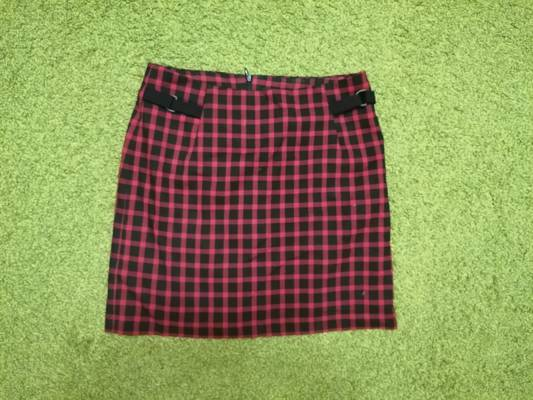

In [132]:
imgs[0]

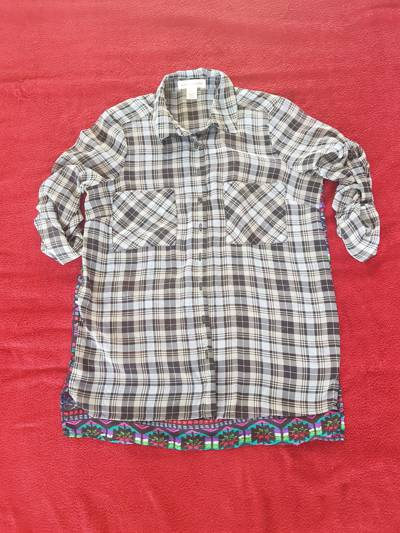

In [133]:
imgs[1]

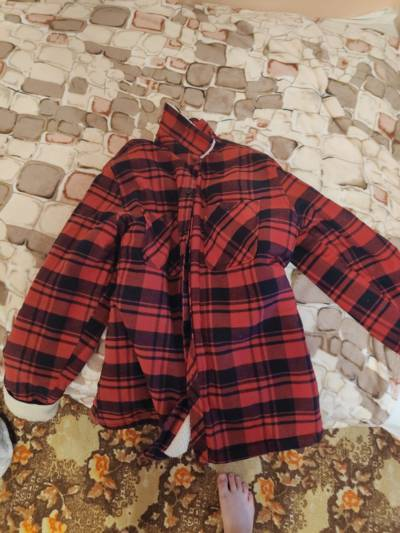

In [134]:
imgs[2]

### Limitations of semantic search
-- 

## Let's try Full-text search/ BM25

In [128]:
tbl.create_fts_index("Description", replace=True)

In [139]:
rs = tbl.search(dummy_model_response, query_type="fts").limit(5).to_pandas()
rs

,filename,Description,vector,Title,Size,Category,Type,Gender,_score
0,0e20abb0-d56a-4f83-b254-9db70fb92794.jpg,"This shirt is a long-sleeved, black and grey s...","[-0.045025624, 0.041662034, -0.0006505165, 0.0...",Black and Grey Striped Shirt with Pink Accents,S,Tops,Casual,F,52.089787
1,10e51a41-3729-472e-b288-f3b8f895577a.jpg,This plaid shirt features a classic plaid patt...,"[-0.044541422, 0.05006024, -0.04257077, 0.0401...",Plaid shirt with embroidered hem,L,Tops,Casual,F,35.616638
2,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F,34.096905
3,64c5d20e-7cec-4965-8c50-315389f44b22.jpg,These light washed blue jeans are distressed w...,"[-0.07545003, 0.05375045, 0.00353413, -0.01551...",Light Washed Blue Ripped Jeans,L,Jeans,Casual,M,29.116760
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,This red flannel plaid shirt has a classic and...,"[-0.03013145, 0.060508166, -0.03642542, 0.0301...",Red Flannel Plaid Shirt,S,Shirts,Casual,M,28.444168


In [140]:
imgs = show_image_from_response(rs)

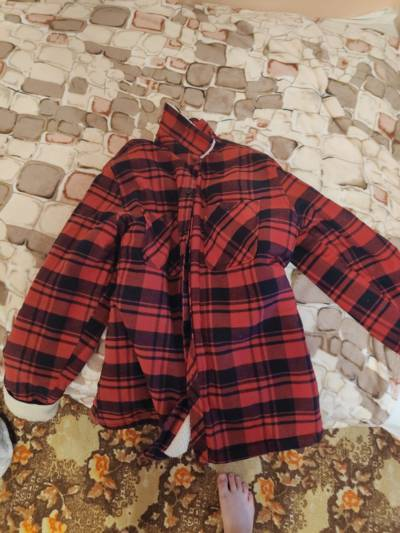

In [145]:
imgs[-1]

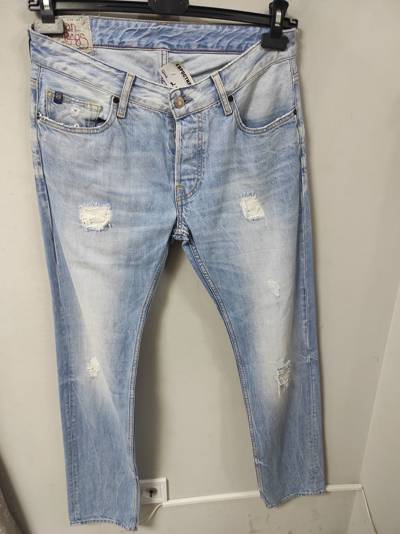

In [146]:
imgs[-2]

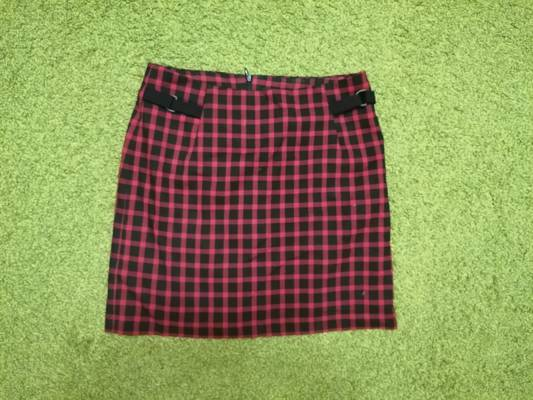

In [148]:
imgs[-3]

### Hybrid search
 
 
-- Let's use ColBert Reranker

In [153]:
reranker = ColbertReranker(column="Description")
rs = tbl.search(dummy_model_response, query_type="hybrid").rerank(reranker=reranker).limit(5).to_pandas()
rs

Loading ColBERTRanker model colbert-ir/colbertv2.0
No device set
Using device cuda
No dtype set
Using dtype torch.float16
Loading model colbert-ir/colbertv2.0, this might take a while...
Linear Dim set to: {linear_dim} for downcasting


,filename,Description,vector,Title,Size,Category,Type,Gender,_relevance_score
0,0e20abb0-d56a-4f83-b254-9db70fb92794.jpg,"This shirt is a long-sleeved, black and grey s...","[-0.045025624, 0.041662034, -0.0006505165, 0.0...",Black and Grey Striped Shirt with Pink Accents,S,Tops,Casual,F,0.744141
1,10e51a41-3729-472e-b288-f3b8f895577a.jpg,This plaid shirt features a classic plaid patt...,"[-0.044541422, 0.05006024, -0.04257077, 0.0401...",Plaid shirt with embroidered hem,L,Tops,Casual,F,0.735352
2,300a4125-acec-46aa-b0b9-68b4b2142c70.jpg,These plaid shorts are a stylish and comfortab...,"[-0.002765015, 0.030705247, -0.010424565, -0.0...",Plaid Shorts,S,Pants,Casual,M,0.728516
3,bd289469-607c-45df-bad3-ed1057e277bf.jpg,This is a red and black plaid skirt with a cla...,"[-0.021971317, 0.12156065, -0.002515854, 0.034...",Red and Black Plaid Skirt,S,Skirts,Casual,F,0.699219
4,b0c03127-9dfb-4573-8934-1958396937bf.jpg,This red flannel plaid shirt has a classic and...,"[-0.03013145, 0.060508166, -0.03642542, 0.0301...",Red Flannel Plaid Shirt,S,Shirts,Casual,M,0.679199


In [154]:
imgs = show_image_from_response(rs)

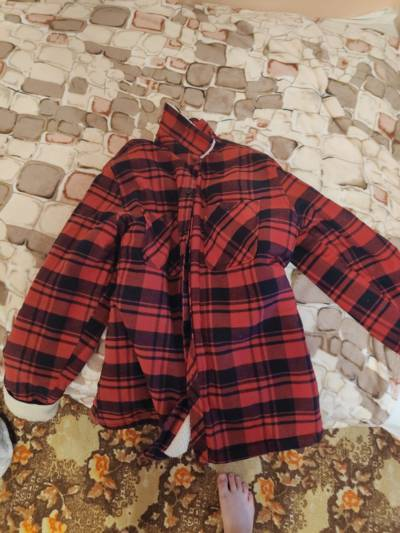

In [155]:
imgs[-1]

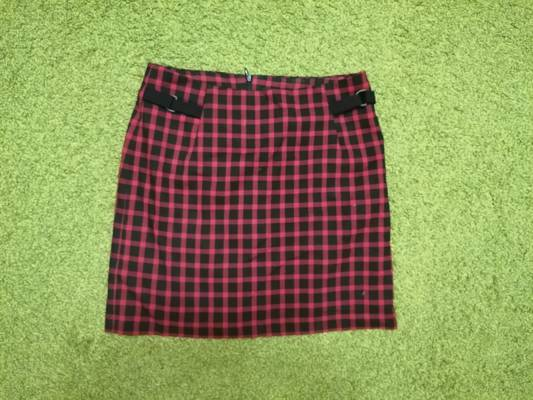

In [156]:
imgs[-2]